In [2]:

from keras.utils import np_utils

import cv2 

import numpy as np
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Activation, AveragePooling2D,BatchNormalization
from keras.models import Model

import matplotlib.pyplot as plt
import tensorflow as tf
import random
import seaborn as sns
import os
import keras
from pathlib import Path
from tensorflow.keras.utils import to_categorical
from collections import Counter
from plotly.subplots import make_subplots
from tensorflow.keras.layers.experimental import preprocessing as ps
from sklearn.model_selection import train_test_split



In [5]:


path = Path("./Data")
covid_without_PNEUMONIA_train_path = path / 'train' / 'covid_without_PNEUMONIA'
covid_with_PNEUMONIA_train_path = path / 'train' / 'covid_with_PNEUMONIA'

covid_without_PNEUMONIA_test_path = path / 'test' / 'covid_without_PNEUMONIA'
covid_with_PNEUMONIA_test_path = path / 'test' / 'covid_with_PNEUMONIA'


In [6]:
covid_without_PNEUMONIA_path = [covid_without_PNEUMONIA_train_path, covid_without_PNEUMONIA_test_path]
covid_with_PNEUMONIA_path = [covid_with_PNEUMONIA_train_path, covid_with_PNEUMONIA_test_path]

In [8]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [9]:
np.random.seed(42)
random.seed(42)

In [12]:
label2category = {'covid_without_PNEUMONIA': 0, 'covid_with_PNEUMONIA': 1}
category2label = {0: 'covid_without_PNEUMONIA', 1: 'covid_with_PNEUMONIA'}

In [13]:
data = []

for path in covid_without_PNEUMONIA_path:
    for img in path.glob('*.jpeg'):
        data.append({'img_path': str(img), 'label': 'covid_without_PNEUMONIA'})
    
for path in covid_with_PNEUMONIA_path:
    for img in path.glob('*.jpeg'):
        data.append({'img_path': str(img), 'label': 'covid_with_PNEUMONIA'})
        
# np.random.shuffle(data)

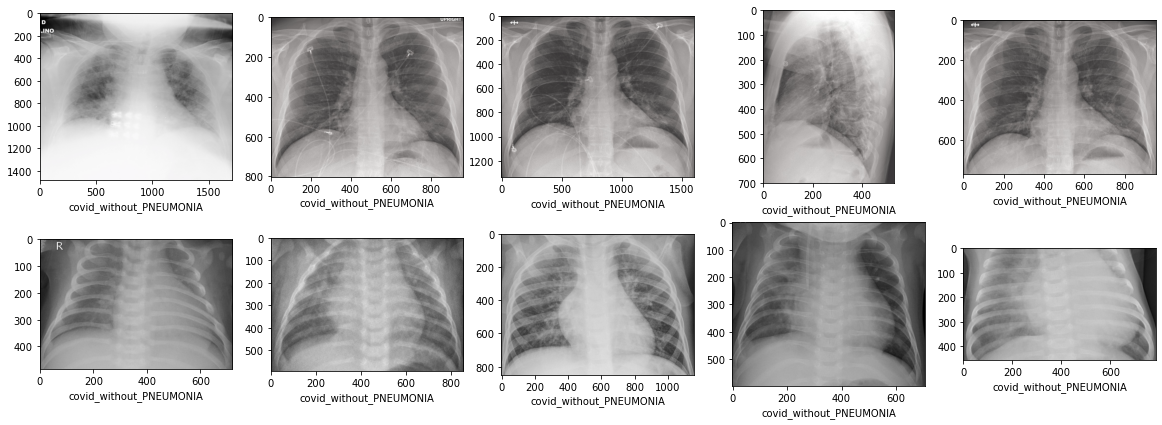

In [14]:
plt.figure(figsize=(20,7))

for i, data_ in enumerate(data[:10]):
    path, label = data_['img_path'], data_['label']
    plt.subplot(2,5,i+1)
    img = cv2.imread(path)
    plt.imshow(img)
    plt.xlabel(label)
    
plt.show()

In [17]:
aug_model = Sequential()
aug_model.add(ps.RandomFlip())

In [18]:
%%time

images_array = []
images_label = []

IMG_SIZE = (64,64)

for data_ in data:
    category = label2category[data_['label']]
    label = to_categorical(category, 2)
    img = cv2.imread(data_['img_path'])

    if category == 0:
        for i in range(2):
            batch = tf.expand_dims(img, 0)
            aug_img = aug_model(batch)
            aug_img = np.array(aug_img[0])
            img = cv2.resize(aug_img, IMG_SIZE)
            img = img / 255
            images_array.append(img)
            images_label.append(label)

    else:

        img = cv2.resize(img, IMG_SIZE)
        img = img / 255
        images_array.append(img)
        images_label.append(label)

Wall time: 26 s


In [19]:
images_array = np.array(images_array)
images_label = np.array(images_label)

print('shape of images array: {}'.format(images_array.shape))
print('shape of images label: {}'.format(images_label.shape))

shape of images array: (575, 64, 64, 3)
shape of images label: (575, 2)


In [21]:
def to_labels(labels):
    label_list = []
    for label in labels:
        am = label.argmax()
        label_list.append(category2label[am])
        
    return Counter(label_list)

In [22]:
x_train, x_test, y_train, y_test = train_test_split(images_array, images_label, test_size=0.2, random_state=10)

print('train input shape: {}'.format(x_train.shape))
print('train output shape: {}'.format(y_train.shape))
print('test input shape: {}'.format(x_test.shape))
print('test output shape: {}'.format(y_test.shape))

train input shape: (460, 64, 64, 3)
train output shape: (460, 2)
test input shape: (115, 64, 64, 3)
test output shape: (115, 2)


In [23]:
model = Sequential()

model.add(Conv2D(32, (3,3), input_shape=(64,64,3), activation='relu'))
# model.add(BatchNormalization())
model.add(MaxPooling2D((2,2), strides=(1,1), padding='same'),)

model.add(Conv2D(64, (3,3), activation='relu'),)
# model.add(BatchNormalization())
model.add(MaxPooling2D((2,2), strides=(1,1), padding='same'),)

model.add(Conv2D(128, (3,3), activation='relu'),)
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2), strides=(1,1), padding='same'),)


model.add(Conv2D(256, (3,3), activation='relu'),)
# model.add(BatchNormalization())
model.add(MaxPooling2D((2,2), strides=(1,1), padding='same'),)

model.add(Conv2D(512, (3,3), activation='relu'),)
# model.add(BatchNormalization())
model.add(MaxPooling2D((2,2), strides=(1,1), padding='same'),)

model.add(Flatten())


# model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))


model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 60, 60, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 58, 58, 128)       73856     
                                                                 
 batch_normalization (BatchN  (None, 58, 58, 128)     

In [24]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
mdl = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50)


Epoch 1/50
15/15 [==============================] - 207s 14s/step - loss: 11.7033 - accuracy: 0.6500 - val_loss: 0.6323 - val_accuracy: 0.7565
Epoch 2/50
15/15 [==============================] - 195s 13s/step - loss: 0.2958 - accuracy: 0.8870 - val_loss: 0.6048 - val_accuracy: 0.6087
Epoch 3/50
15/15 [==============================] - 221s 15s/step - loss: 0.1448 - accuracy: 0.9522 - val_loss: 0.6313 - val_accuracy: 0.5043
Epoch 4/50
15/15 [==============================] - 197s 13s/step - loss: 0.1599 - accuracy: 0.9457 - val_loss: 0.6408 - val_accuracy: 0.5043
Epoch 5/50
15/15 [==============================] - 224s 15s/step - loss: 0.1624 - accuracy: 0.9587 - val_loss: 0.5168 - val_accuracy: 0.8870
Epoch 6/50
15/15 [==============================] - 204s 13s/step - loss: 0.1386 - accuracy: 0.9652 - val_loss: 1.0446 - val_accuracy: 0.4957
Epoch 7/50
15/15 [==============================] - 227s 15s/step - loss: 0.1489 - accuracy: 0.9630 - val_loss: 0.4804 - val_accuracy: 0.9217
Epoch

In [19]:
model.save('./Final_Covid_w_wo_pneumonia.hdf5')